In [27]:
import gudhi
import gudhi.wasserstein

import numpy as np
import matplotlib.pyplot as plt

N = 100
t = np.linspace(0,2*np.pi,N)
unit_circle = np.array([[np.cos(tt), np.sin(tt)] for tt in t])

<AxesSubplot: title={'center': 'Persistence diagram'}, xlabel='Birth', ylabel='Death'>

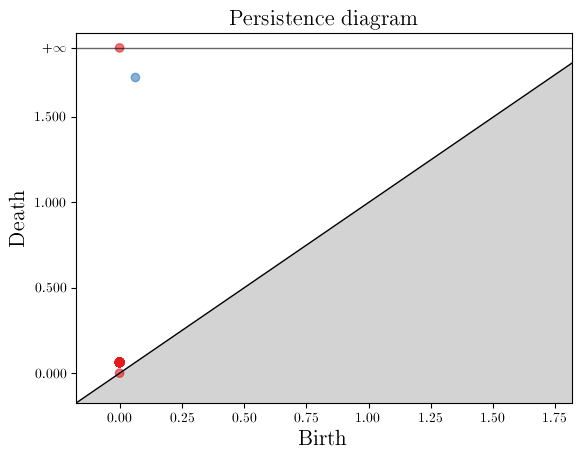

In [28]:
unit_circle_dist = np.array([[np.linalg.norm(p-q) for q in unit_circle] for p in unit_circle])
unit_circle_skeleton = gudhi.RipsComplex( distance_matrix=unit_circle_dist )
unit_circle_rips_simplex = unit_circle_skeleton.create_simplex_tree(max_dimension=2)
unit_circle_barcodes = unit_circle_rips_simplex.persistence()
unit_circle_barcodes_cleaned = np.array([b[1] for b in unit_circle_barcodes])
gudhi.plot_persistence_diagram(unit_circle_barcodes)

# y = [[r2 * np.cos(tt), r2 * np.sin(tt)]
# dgm1 = np.array([[2.7, 3.7],[9.6, 14.],[34.2, 34.974]])
# dgm2 = np.array([[2.8, 4.45],[9.5, 14.1]])

# message = "Wasserstein distance value = " + '%.2f' % gudhi.wasserstein.wasserstein_distance(dgm1, dgm2, order=1., internal_p=2.)
# print(message)


In [ ]:
def get_persistence_info(point_cloud):
    dist_matrix = np.array([[np.linalg.norm(p-q) for q in point_cloud] for p in point_cloud])
    skeleton = gudhi.RipsComplex( distance_matrix=dist_matrix )
unit_circle_rips_simplex = unit_circle_skeleton.create_simplex_tree(max_dimension=2)
unit_circle_barcodes = unit_circle_rips_simplex.persistence()
unit_circle_barcodes_cleaned = np.array([b[1] for b in unit_circle_barcodes])

In [31]:
def my_transformed_f(transformation):
    def helper(data, r):
        tmp = transformation(data,r)
        C = np.array([[np.linalg.norm(p-q) for p in tmp] for q in tmp])
        skel = gudhi.RipsComplex( distance_matrix=C )
        rips_simplex = skel.create_simplex_tree(max_dimension=2)
        barcodes = rips_simplex.persistence()
        bc_cleaned = np.array([b[1] for b in barcodes])
        return gudhi.wasserstein.wasserstein_distance(unit_circle_barcodes_cleaned, bc_cleaned, order=1., internal_p=2.)

In [30]:
        C = np.array([[np.linalg.norm(p-q) for p in tmp] for q in tmp])
        skel = gudhi.RipsComplex( distance_matrix=C )
        rips_simplex = skel.create_simplex_tree(max_dimension=2)
        barcodes = rips_simplex.persistence()
        bc_cleaned = np.array([b[1] for b in barcodes])
        return gudhi.wasserstein.wasserstein_distance(unit_circle_barcodes_cleaned, bc_cleaned, order=1., internal_p=2.)

NameError: name 'tmp' is not defined

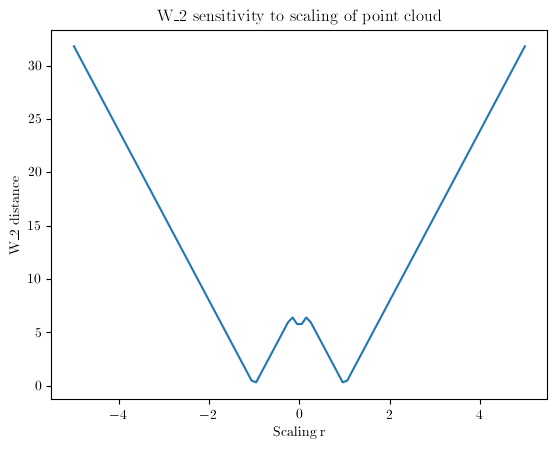

In [ ]:
r = np.linspace(-5.0, 5.0, 100)
u = np.array([my_dist(rr) for rr in r])
plt.plot(r, u)
plt.xlabel('Scaling r')
plt.ylabel('W_2 distance')
plt.title('W_2 sensitivity to scaling of point cloud')
plt.show()